In [1]:
__author__ = 'Kabelo Tsiane <kabelo@uchicago.edu>'
__version__ = '20240522'
__datasets__ = ['des_dr1']  # datasets used in this notebook
__keywords__ = ['strong lensing', 'machine learning'] # keywords relevant to this notebook, e.g. ['science case','dwarf galaxies'] Use only keywords from the master list: https://github.com/astro-datalab/notebooks-latest/blob/master/keywords.txt

# Detecting Strong Lenses in DES DR1

*Kabelo Tsiane*

### Table of contents
* [Goals & notebook summary](#goals)
* [Imports & setup](#import)
* [Introduction](#intro)
* [Dataset](#data)
* [Visualizations](#viz)
* [Model](#model)
* [Results](#results)
* [Future work](#future)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals
To classify images of strong gravitational lenses using Convolutional Neural Networks.

# Summary

We classify images as either strong lenses or not using simulations and DES data. The technique used is Convolutional Neural Networks.

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
# std lib
import os
import sys

# 3rd party # remove imports that are not needed
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from astropy.io import fits
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import ConcatDataset, DataLoader, random_split, TensorDataset
import torch.optim as optim
import torchvision.transforms as transforms

<a class="anchor" id="intro"></a>
# Introduction

In this project I will train an artificial neural network to detect strong gravitational lensing systems. Such an analysis has classically been done manually, yielding hundreds of confirmed galaxy-galaxy lensing systems. But in an era of large astronomical surveys such as Euclid and LSST we expect tens of thousands of these systems to be detected in which case a manual search would be too time consuming. By developing this automated approach, particularly for high redshift (z>0.8) systems, the scientific commmunity stands to benefit from a much more efficient process that will help create large enough databases for these systems for constraining cosmological and galaxy formation models.

<a class="anchor" id="data"></a>
# Dataset 

The dataset is a combination of simulated data and real Dark Energy Survey Data Release 1 data. The simulated dataset I use is a subset of the simulations generated by Jacobs et al. (2019) using the LENSPOP software. All simulations feature elliptical galaxies as lenses with singular isothermal ellipsoid mass profiles and elliptical De Vaucouleurs light profiles. Sources are appropriately modelled as exponential disks to reflect the fact that these are distant sources meant to cover a broad range of redshifts. 

Simulated images are made using the GRAVLENS ray-tracing code and include seeing and shot noise appropriate for DES imaging in the g, r and i-bands. Simulated images are also combined with random patches of DES imaging to achieve realistic sky noise, foreground objects and other contaminants.

DES data was captured using the Dark Energy Camera (DECam), mounted on the 4-meter Blanco Telescope in Chile. DECam has five optical lenses, and five image filters (g, r, i, z, Y) spanning the optical to near-infrared end of the spectrum. DR1 data represents the co-add data products from 345 nights of observations, covering about $5000\,deg^2$. The co-add astrometric precision is 30 mas, the co-add photometric precision (i-band) is 4 mmag and the co-add magnitude limit (1.95 arcsec aperture, S/N=10, i-band) is 23.44 mag.

The training set has dimensions (1600 x 3 x 100 x 100) \
The testing set has dimensions (400 x 3 x 100 x 100) \
The DES data has dimensions (14 x 3 x 100 x 100)

<a class="anchor" id="viz"></a>
## Visualizations

In [3]:
labels_map = {
    0: "Non lens",
    1: "Lens"
}

I perform image normalization which projects pixel values to the range [0, 1]. Image normalization is an important data preprocessing step that provides several benefits:
- Improved training stability
- Faster convergence
- Enhanced generalization
- Regularization
- Efficient gradient descent


In [4]:
def rescale(images):
    """Rescaling the images has been shown to improve network performance. 
    Jacobs et al. describe their rescaling on page 6, and we adjust a bit from that.
    """
    mu = 0.612
    sigma = 200.0
    images = (images - mu)/(sigma/2.5)
    np.clip(images,0,1,images)
    return images

In [5]:
def image_tile(dataset, labels_map):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 2, 2
    for i in range(1, cols * rows + 1):
        idx = np.random.randint(low=0, high=len(dataset))
        img, label = dataset[idx]
        img = img.permute(1, 2, 0)   # convert to channel last for plotting
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img)
    plt.show()
    return

In [6]:
def images_hists(dataset, labels_map=None, title=None):
    fig, ax = plt.subplots(2, 3, figsize=(13, 6))
    for i in range(3):
        idx = np.random.randint(low=0, high=len(dataset))
        if labels_map:
            img, label = dataset[idx]
        else:
            img = dataset[idx]
        img = img.permute(1, 2, 0)    # convert to channel last for plotting
        ax[0][i].imshow(img)
        ax[0][i].axis('off')
        ax[1][i].hist(torch.flatten(img),bins=50,log=True)
        ax[1][i].set_xlabel('Pixel Value')
        if title:
            plt.suptitle(title,fontsize=16,y=0.95)

In [7]:
def load_data_from_folder(filename, label=None, norm=True):
    data = []
    if filename.endswith('.fits.gz'):
        hdulist = fits.open(filename)
        image_data = hdulist[0].data
        if norm:
            image_data = rescale(image_data)
        if image_data.dtype.byteorder != '=':
            image_data = image_data.byteswap().newbyteorder()
        image_tensor = torch.tensor(image_data, dtype=torch.float32).permute(0, 3, 1, 2)       # convert to channels-first format
        if label or (label is not None):
            for im in image_tensor:
                data.append((im, label))
        else:
            data = image_tensor
    else:
        print("Error. Bad file extension")
    return data

In [8]:
# Paths to lens and non lens folders
lens_folder = 'data/lens/des_sims_lens_1000.fits.gz'
non_lens_folder = 'data/no_lens/des_sims_nonlens_1000.fits.gz'
des_folder = 'data/des_data.fits.gz'

# Load data from each folder
lens_data = load_data_from_folder(lens_folder, 1)  # Assign label 1 for lens
non_lens_data = load_data_from_folder(non_lens_folder, 0)  # Assign label 0 for non-lens
des_data = load_data_from_folder(des_folder)

concatenated_dataset = ConcatDataset([lens_data, non_lens_data])

train_size = int(0.8 * len(concatenated_dataset))
test_size = len(concatenated_dataset) - train_size

# Use random_split to split the concatenated dataset into training and testing sets
train_dataset, test_dataset = random_split(concatenated_dataset, [train_size, test_size])

# Create DataLoader for the training and testing datasets
batch_size = 32 
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
pad = 20*'-'
names = [pad+' Simulated Lenses '+pad,
         pad+' Simulated Non-Lenses '+pad,
         pad+' Real DES Data '+pad]

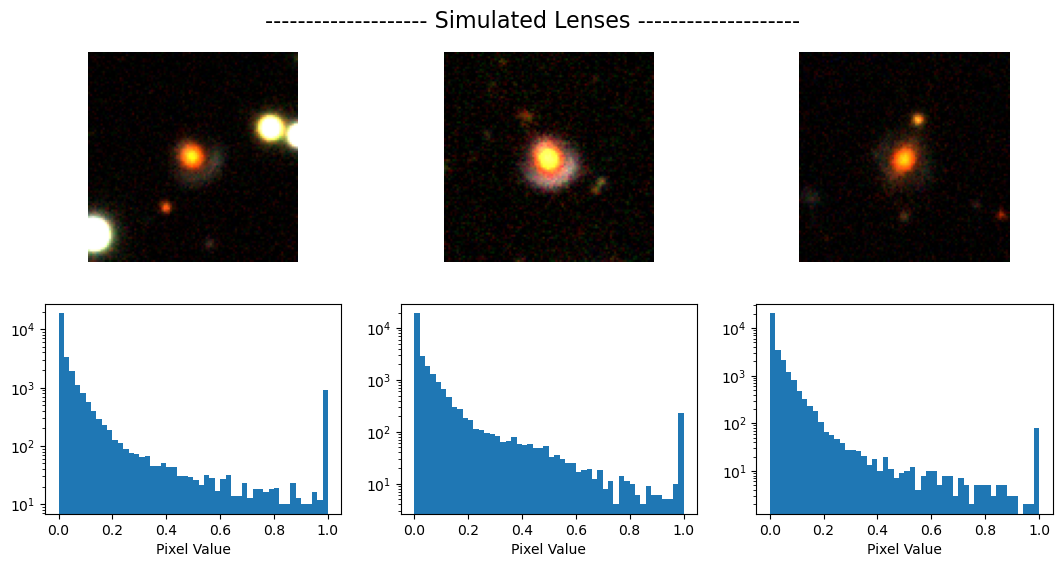

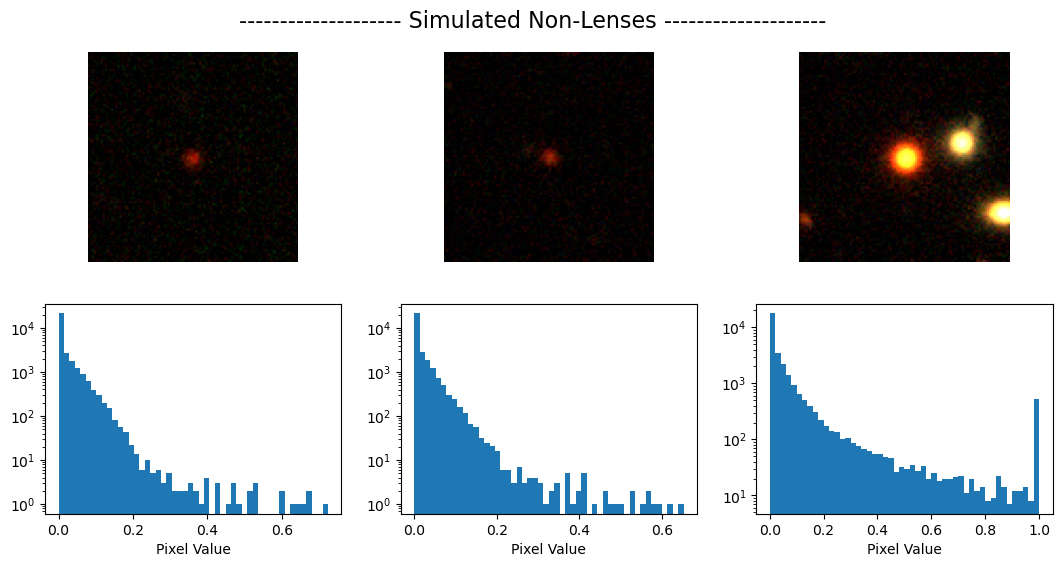

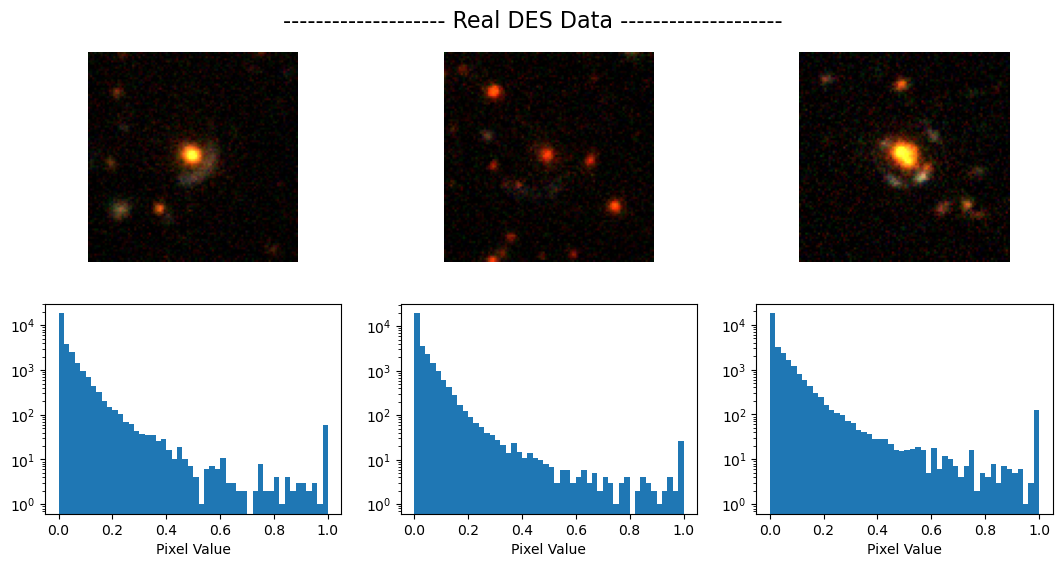

In [10]:
# Plots of simulated lenses and real DES data
images_hists(lens_data, labels_map, title=names[0])
images_hists(non_lens_data, labels_map, title=names[1])
images_hists(des_data, title=names[2])

<a class="anchor" id="model"></a>
# Model

For this analysis I will train a Convolutional Neural Network on DES-like data to assess the viability of neural networks for detecting strong lenses. For the analysis we assume DES-like data, that is, images with dimensions (3 x 100 x 100). Due to the stohasticity of training an artificial neural network the nature of this modelling method is such that there will be uncertainties for any model predictions, which are presented in the results as the probability of an image being a lens or not being a lens.

There are several differences between this notebook and what was explored in the ASTR 28500 class. My CNN includes four convolutional layers as opposed to the one from class. I also include batch normalization after each convolution and only one dropout of 0.25. I also have more images in my training set but less in my testing set relative to the class. I evaluate the performance of the model based on the test set accuracy alone.

Some other implementations I explored included expanding the CNN to have up to eight convolutional layers. However, after four layers there is only a noticeable increase in training time and not performance. I explored training over more than two epochs but found that after about three epochs the model rarely learned any meaningful patterns. During the data preprocessing I explored normalizing pixels values to [-1, 1] instead of [0, 1] but this actually decreased model performance. 



In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 2D convolution layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=11, stride=1, padding='same')
        self.bn1 = nn.BatchNorm2d(num_features=8)

        # 2D convolution layer
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding='same')
        self.bn2 = nn.BatchNorm2d(num_features=16)

        # 2D convolution layer
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.bn3 = nn.BatchNorm2d(num_features=32)

        # 2D convolution layer
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.bn4 = nn.BatchNorm2d(num_features=64)
        
        # Max pool layer that reduces 100x100 images to 99x99
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1)

        self.drop = nn.Dropout(p=0.25)
        
        self.fc1 = nn.Linear(in_features=64 * 96 * 96, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=2)

    def forward(self, x):
        x = x.view(-1, 3, 100, 100)
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        x = x.view(-1, 64 * 96 * 96)
        x = self.drop(F.relu(self.fc1(x)))
        x = F.softmax(self.fc2(x), dim=1)
        return x

model = Net()
summary(model, input_size=(3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 100, 100]           2,912
       BatchNorm2d-2          [-1, 8, 100, 100]              16
         MaxPool2d-3            [-1, 8, 99, 99]               0
            Conv2d-4           [-1, 16, 99, 99]           3,216
       BatchNorm2d-5           [-1, 16, 99, 99]              32
         MaxPool2d-6           [-1, 16, 98, 98]               0
            Conv2d-7           [-1, 32, 98, 98]           4,640
       BatchNorm2d-8           [-1, 32, 98, 98]              64
         MaxPool2d-9           [-1, 32, 97, 97]               0
           Conv2d-10           [-1, 64, 97, 97]          18,496
      BatchNorm2d-11           [-1, 64, 97, 97]             128
        MaxPool2d-12           [-1, 64, 96, 96]               0
           Linear-13                   [-1, 32]      18,874,400
          Dropout-14                   

In [12]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_processed = 0
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        optimizer.zero_grad()
        loss = loss_fn(pred, y)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        total_processed += len(X)
        
    print(f"loss: {loss:>7f}  [{total_processed:>5d}/{size:>5d}]")

In [13]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
model = Net()
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, model, criterion, optimizer)
    test(test_dataloader, model, criterion)
print("Done!")

Epoch 1
-------------------------------
loss: 0.681893  [ 1600/ 1600]
Test Error: 
 Accuracy: 53.2%, Avg loss: 0.687004 

Epoch 2
-------------------------------
loss: 0.702093  [ 1600/ 1600]
Test Error: 
 Accuracy: 53.0%, Avg loss: 0.689527 

Epoch 3
-------------------------------


<a class="anchor" id="results"></a>
# Results

In [ ]:
model.eval()
figure = plt.figure(figsize=(16, 16))
cols, rows = 3, 3
with torch.no_grad():
    for c, (x, y) in enumerate(test_dataloader):
        # Make predictions
        preds = model(x)
        predicted_labels = preds.argmax(dim=1)
        for i in range(1, cols * rows + 1):
            idx = np.random.randint(low=0, high=len(x))
            img= x[idx]
            img = img.permute(1, 2, 0)   # convert to channel last for plotting
            figure.add_subplot(rows, cols, i)
            plt.title(f'Lens: {preds[idx][1]:.3f}, Non Lens: {preds[idx][0]:.3f}, Actual: {labels_map[y[idx].item()]}')
            plt.axis("off")
            plt.imshow(img)
        break

<a class="anchor" id="future"></a>
# Future work

There are a couple of possibleFor this analysis I will train a neural network on DES-like data to assess the viability of neural networks avenues to extend this analysis:

- Increased training and testing set sizes through data augmentation, generating more simulations and making more confirmed observations of strong lensing systems
- Performing hyperparameter optimizations to fine tune the model parameters

<a class="anchor" id="resources"></a>
# Resources and references

Jacobs et al. 2019 "Finding high-redshift strong lenses in DES using convolutional
neural networks". https://arxiv.org/abs/1811.03786